In [21]:
import pandas as pd
import re
import os
import numpy as np
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import cmudict
import string
from collections import Counter
import matplotlib.pyplot as plt
import chardet
from zipfile import ZipFile
import spacy
from wordcloud import WordCloud
try:
  from spacy_syllables import SpacySyllables
except ModuleNotFoundError:
  !pip install spacy_syllables
  from spacy_syllables import SpacySyllables

In [3]:
df=pd.read_excel('/content/Input.xlsx')
df.head()

,URL_ID,URL
0,blackassign0001,https://insights.blackcoffer.com/rising-it-cit...
1,blackassign0002,https://insights.blackcoffer.com/rising-it-cit...
2,blackassign0003,https://insights.blackcoffer.com/internet-dema...
3,blackassign0004,https://insights.blackcoffer.com/rise-of-cyber...
4,blackassign0005,https://insights.blackcoffer.com/ott-platform-...


In [4]:
df.shape

(100, 2)

In [5]:
dirname_text='text_files'
def scrape_to_text(dirname):
  f=dirname
  os.mkdir(f)
  no_art=[]
  for art in range(len(df)):
    url=df['URL'][art]
    url_id=str(df['URL_ID'][art])
    response=requests.get(url)
    if response:
      html=BeautifulSoup(response.content,'lxml')
      if '404' not in html.find('h3',class_='tdm-title tdm-title-md').text:
        title=html.find('h1').text
        art_tag=html.find('div',class_='td-post-content tagdiv-type')
        if art_tag!=None:
          article=art_tag.text.strip()
          article=title+re.sub(r'Blackcoffer.*','',article)
        else:
          li=html.find_all('p',class_=False)
          article=' '.join([p.text.strip() for p in li])
        if os.path.exists(f) and os.path.isdir(f):
            ftext=os.path.join(f,url_id+'.txt')
            with open(ftext,'w') as file:
              file.write(article)
scrape_to_text(dirname_text)


In [7]:
#Some were not scraped as they were found to be error or deleted
print('No of articles scraped from 100:',len(os.listdir(dirname_text)))

No of articles scraped from 100: 98


In [8]:
#Loading all text files in directory into a list(dir_name is folder u scraped articles text to)
def load_text_files(dir_name):
  text_list=[]
  text_files=os.listdir(dir_name)
  text_files_sorted=sorted(text_files)
  for fi in text_files:
    fname=os.path.join(dir_name,fi)
    with open(fname,'r',encoding='utf-8') as myfile:
      text_list.append(myfile.read().strip().lower().replace('\uf0b7','').replace('“','').replace('’','').replace('”',''))
  return text_list

In [9]:
#function to extract zip files
def extract_zipfiles(file):
  zf=ZipFile(file)
  zf.extractall()
  zf.close()
extract_zipfiles('/content/StopWords-20231212T055033Z-001.zip')

In [10]:
#Generates list of stopwords from folder given and preprocesses it
def stopwords_corpus(dir_name):
  stopwords=[]
  file_stop=dir_name
  for f in os.listdir(file_stop):
    fname=os.path.join(file_stop,f)
    #To check or use efficient encoding of a text use chardet library
    #chardet.detect(text)['encoding']
    if 'Currencies' in fname:
      with open(fname,'r',encoding='ISO-8859-1') as stop_w:
        words=stop_w.read().strip().lower()
        stopwords.extend(re.sub(r'\s*\|\s*.*','',words).split('\n'))
    else:
      with open(fname,'r') as stop_w:
        words=stop_w.read().strip().lower()
        stopwords.extend(re.sub(r'\s*\|\s*.*','',words).split('\n'))
  return stopwords

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
punc=string.punctuation

In [13]:
punc

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
#Preprocessed tokens without stopwords or punctuation
def cleaned_text(text_list,stopwords):
  token_list=[]
  sent_list=[]
  for i in range(len(text_list)):
    tokens=[word_tokenize(sent) for sent in sent_tokenize(text_list[i])]
    new_tokens_1=[t for s in tokens for t in s if t not in stopwords and t not in punc]
    new_tokens_2=[[t for t in s if t not in stopwords and t not in punc] for s in tokens]
    token_list.append(new_tokens_1)
    sent_list.append(new_tokens_2)
  return token_list,sent_list

In [15]:
#Function to get entire corpus,count of words,sentences in each article
def all_counts(token_list,sent_list):
  token_corpus=[w for art in token_list for w in art]
  word_count=[len(s) for s in token_list]
  sent_count=[len(s) for s in sent_list]
  return token_corpus,word_count,sent_count

In [18]:
dirname_stop='StopWords'
text_list=load_text_files(dirname_text)
stopwords=stopwords_corpus(dirname_stop)
token_list,sent_list=cleaned_text(text_list,stopwords)
token_corpus,word_count,sent_count=all_counts(token_list,sent_list)
total_words=len(token_corpus)
print('Total Number of words :',total_words)

Total Number of words : 52081


In [19]:
unique_words=set(token_corpus)
total_unique_words=len(unique_words)
print('Number of unique words:',total_unique_words)

Number of unique words: 9795


In [20]:
count=Counter(token_corpus)
print('Top 10 frequent words:',count.most_common(10))

Top 10 frequent words: [('data', 345), ('people', 316), ('world', 241), ('future', 211), ('technology', 208), ('healthcare', 194), ('human', 181), ('work', 178), ('learning', 178), ('time', 172)]


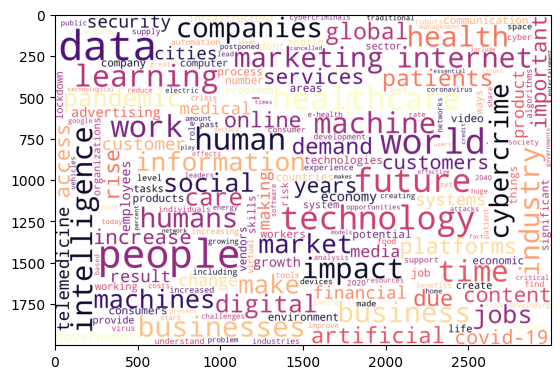

In [22]:
wc=WordCloud(width=3000,height=2000,background_color='white',colormap='magma',max_font_size=250,min_font_size=15).generate_from_frequencies(count)
plt.imshow(wc)
plt.show()

In [23]:
def pos_neg(pos_file,neg_file):
  with open(pos_file,'r') as pos:
    p_text=pos.read()
    pos_words=p_text.split()
  with open(neg_file,'r',encoding='ISO-8859-1') as neg:
    n_text=neg.read()
    neg_words=n_text.split()
  return pos_words,neg_words

In [24]:
pos_file,neg_file='positive-words.txt','negative-words.txt'
pos_words,neg_words=pos_neg(pos_file,neg_file)
print('Number of positive words given:',len(pos_words))
print('Number of negative words given:',len(neg_words))

Number of positive words given: 2006
Number of negative words given: 4783


In [25]:
art_pos_words=[w for w in token_corpus if w in pos_words]
art_neg_words=[w for w in token_corpus if w in neg_words]
print('Total number of positive words in text files:',len(art_pos_words))
print('Total number of negative words in text files:',len(art_neg_words))

Total number of positive words in text files: 3156
Total number of negative words in text files: 2599


In [26]:
def no_url_index(dir_name):
  no_art_index=[]
  files=os.listdir(dir_name)
  for i in range(1,len(files)+1):
    if str(i) in ' '.join(files):
      continue
    else:
      no_art_index.append(i-1)
  return no_art_index

In [27]:
def pos_neg_scores(token_list):
  positive_score=[]
  negative_score=[]
  for art in token_list:
    p_score=0
    n_score=0
    for w in art:
      if w in pos_words:
        p_score+=1
      if w in neg_words:
        n_score-=1
    positive_score.append(p_score)
    negative_score.append(n_score*-1)
  return positive_score,negative_score

In [28]:
#polarity score should be between -1 to +1
positive_score,negative_score=pos_neg_scores(token_list)
p,n=np.array(positive_score),np.array(negative_score)
polarity_score=(p-n)/((p+n)+0.000001)
polarity_score

array([ 0.49019607, -0.42424242,  0.31578947,  0.21739129,  0.63636362,
        0.22033898, -0.375     , -0.14285712,  0.42857137,  0.3030303 ,
        0.27777777, -0.31707317,  0.07246377, -0.225     ,  0.        ,
        0.48717948, -0.12      ,  0.42222221, -0.28358209, -0.08571428,
       -0.29824561,  0.2       , -0.43999998,  0.38461537,  0.14285714,
        0.62499998,  0.49999998,  0.57142853,  0.42857137,  0.49999999,
       -0.08333333,  0.52212389,  0.03225806, -0.4137931 ,  0.99999975,
        0.10144927, -0.22807017, -0.14893617, -0.49999999, -0.39583333,
        0.48571427,  0.44615384,  0.3125    ,  0.63333332, -0.30666666,
        0.54455445, -0.29411764,  0.39784946,  0.20833333,  0.16666666,
        0.2       ,  0.41463414, -0.34426229,  0.29670329, -0.17263844,
        0.26190476,  0.13333333,  0.7391304 ,  0.04761905, -0.56435643,
        0.81249999,  0.49999988,  0.5135135 ,  0.51515151,  0.2745098 ,
       -0.33333333,  0.54838708,  0.09433962,  0.99999996, -0.17

In [29]:
print(polarity_score.min())
print(polarity_score.max())

-0.5999999800000007
0.999999958333335


In [30]:
polarity_score.shape

(98,)

In [31]:
w_array=np.array(word_count)
s_array=np.array(sent_count)

In [32]:
# This is the score that determines if a given text is objective or subjective. Should be between 0 to 1
subjectivity_score=(p+n)/((w_array)+0.000001)
subjectivity_score

array([0.18613139, 0.1314741 , 0.16642336, 0.16083916, 0.21019108,
       0.09735974, 0.14746544, 0.05      , 0.03431373, 0.11934901,
       0.10285714, 0.19294118, 0.10935024, 0.10457516, 0.08219178,
       0.11487482, 0.09933775, 0.14195584, 0.14016736, 0.10948905,
       0.17538461, 0.12666667, 0.10964912, 0.07784431, 0.10526316,
       0.06438632, 0.10094637, 0.06140351, 0.09459459, 0.07476636,
       0.08955224, 0.11078431, 0.10032362, 0.06553672, 0.05063291,
       0.10207101, 0.1425    , 0.10444444, 0.14330218, 0.11985019,
       0.06529851, 0.10708402, 0.1046892 , 0.10638298, 0.09433962,
       0.12227603, 0.12035398, 0.14645669, 0.17235188, 0.05529954,
       0.09532062, 0.12480974, 0.0995106 , 0.09578947, 0.18416317,
       0.12068965, 0.09630819, 0.08712121, 0.12650602, 0.24337349,
       0.07843137, 0.07843137, 0.07889126, 0.08450704, 0.124847  ,
       0.18845501, 0.1009772 , 0.08589951, 0.09836066, 0.16194332,
       0.10645724, 0.07130435, 0.05066079, 0.08893281, 0.02747

In [33]:
subjectivity_score.min()

0.025516403386685052

In [34]:
subjectivity_score.max()

0.24337349338946146

In [35]:
avg_sent_len=w_array/s_array
avg_sent_len

array([11.41666667, 10.04      , 85.625     ,  5.2962963 ,  9.8125    ,
       10.82142857,  9.43478261, 12.72727273, 17.        ,  9.06557377,
       15.90909091, 15.17857143, 11.68518519, 10.92857143,  7.3       ,
        8.81818182,  9.32098765,  9.05714286,  8.24137931,  8.79816514,
        5.90909091,  6.81818182, 12.        ,  8.78947368, 14.77777778,
        7.765625  , 14.40909091,  8.44444444,  8.22222222, 11.63043478,
       11.65217391, 12.59259259, 11.03571429, 16.09090909,  7.9       ,
        5.68067227, 10.81081081, 12.5       , 11.67272727, 13.81034483,
       11.65217391, 11.03636364, 11.4625    ,  9.09677419, 10.89041096,
       10.4556962 , 12.55555556,  6.68421053,  7.14102564, 11.72972973,
       10.12280702, 10.7704918 , 11.56603774, 12.5       ,  7.27947598,
        8.81012658, 10.38333333, 13.89473684,  6.38461538,  5.12345679,
        8.58947368,  7.28571429, 13.02777778,  8.48913043,  9.72619048,
       12.80434783,  5.03278689,  7.7125    , 11.61904762,  6.76

In [36]:
nlp=spacy.load('en_core_web_sm')
nlp.add_pipe('syllables',after='tagger')
pipes=nlp.pipe_names
assert pipes==['tok2vec', 'tagger','syllables', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [37]:
#Function to calculate complex words based on more than 2 syllables
def calculate_complex(token_list):
  complex_words=[]
  for art in token_list:
    count=0
    for w in art:
      x=nlp(w)
      sy=[i._.syllables_count for i in x]
      sy_c=sum([i for i in sy if i is not None])
      if sy_c>2:
        count+=1
    complex_words.append(count)
  return complex_words

In [38]:
complex_words=calculate_complex(token_list)
len(complex_words)

98

In [39]:
c_array=np.array(complex_words)
per_complex_words=c_array/w_array
per_complex_words

array([0.4270073 , 0.41434263, 0.32116788, 0.31468531, 0.44585987,
       0.49339934, 0.3671275 , 0.40714286, 0.35784314, 0.32730561,
       0.29714286, 0.35058824, 0.29318542, 0.31633987, 0.24657534,
       0.35640648, 0.29403974, 0.2555205 , 0.29079498, 0.28675704,
       0.27692308, 0.38266667, 0.38596491, 0.38323353, 0.34022556,
       0.25754527, 0.39432177, 0.21929825, 0.27027027, 0.38878505,
       0.28731343, 0.4254902 , 0.34951456, 0.35141243, 0.35443038,
       0.3964497 , 0.325     , 0.35777778, 0.31308411, 0.34956305,
       0.25186567, 0.37891269, 0.33587786, 0.34219858, 0.41761006,
       0.28571429, 0.23539823, 0.32440945, 0.31059246, 0.24654378,
       0.39861352, 0.33333333, 0.30179445, 0.37263158, 0.45770846,
       0.43534483, 0.33065811, 0.32954545, 0.37951807, 0.2746988 ,
       0.39583333, 0.25490196, 0.49040512, 0.32138284, 0.38433293,
       0.49405772, 0.26710098, 0.27876823, 0.38114754, 0.31376518,
       0.30890052, 0.31652174, 0.37444934, 0.35968379, 0.23626

In [40]:
fog_index=0.4*(avg_sent_len+per_complex_words)
fog_index

array([ 4.73746959,  4.18173705, 34.37846715,  2.24439264,  4.10334395,
        4.52593116,  3.92076404,  5.25376623,  6.94313725,  3.75715175,
        6.48249351,  6.21166387,  4.79134824,  4.49796452,  3.01863014,
        3.66983532,  3.84601096,  3.72506534,  3.41286972,  3.63396887,
        2.47440559,  2.88033939,  4.95438596,  3.66908289,  6.04720134,
        3.20926811,  5.92136507,  3.46549708,  3.396997  ,  4.80768793,
        4.77579494,  5.20723312,  4.55409154,  6.57692861,  3.30177215,
        2.43084879,  4.45432432,  5.14311111,  4.79432455,  5.66396315,
        4.76161583,  4.56611053,  4.71935115,  3.77558911,  4.52320841,
        4.2965642 ,  5.11638151,  2.80344799,  2.98064724,  4.7905094 ,
        4.20856821,  4.44153005,  4.74713288,  5.14905263,  3.09487378,
        3.69818856,  4.28559658,  5.68971292,  2.70565338,  2.15926223,
        3.59412281,  3.0162465 ,  5.40727316,  3.52420531,  4.04420936,
        5.31936222,  2.11995514,  3.19650729,  4.80007806,  2.83

In [41]:
avg_words_per_sentence=total_words/sum(sent_count)
avg_words_per_sentence

9.552641232575201

In [42]:
char_count=[sum([len(w) for w in art]) for art in token_list]

In [43]:
char_array=np.array(char_count)
avg_word_len=char_array/w_array

In [44]:
avg_word_len

array([8.22262774, 7.75896414, 7.17080292, 7.92307692, 7.34394904,
       8.41749175, 7.35791091, 7.52142857, 7.68137255, 7.25316456,
       7.38571429, 7.41176471, 7.00792393, 7.15555556, 6.67123288,
       7.33873343, 7.2410596 , 6.83911672, 6.93933054, 7.0552659 ,
       6.78153846, 7.388     , 7.34210526, 8.00598802, 7.56015038,
       6.77062374, 7.56782334, 6.49561404, 7.05405405, 7.81869159,
       6.66231343, 8.22647059, 7.16828479, 7.2440678 , 7.69620253,
       7.49852071, 6.8425    , 7.34222222, 7.16666667, 7.38202247,
       6.47761194, 7.86655684, 7.2606325 , 7.62234043, 7.78238994,
       7.8874092 , 6.66017699, 7.07086614, 7.19210054, 6.61290323,
       7.92894281, 7.48097412, 7.02936378, 7.72315789, 8.08818236,
       7.76724138, 7.5858748 , 7.47348485, 7.54819277, 7.06987952,
       7.74142157, 6.70588235, 8.32409382, 7.20486556, 7.72582619,
       8.21052632, 7.2019544 , 6.86547812, 7.92213115, 7.08097166,
       7.4904014 , 7.23478261, 7.2907489 , 7.49011858, 6.73076

In [45]:
#calculates number of personal pronouns in each article
def calculate_personal_pronouns(text_list):
  personal_pronouns = ["I", "you", "he", "she", "it", "we", "they"]
  pp_count=[]
  for art in text_list:
    count=0
    for i in personal_pronouns:
      if f' {i} ' in art:
        c=text_list[0].count(f' {i} ')
        count+=c
    pp_count.append(count)
  return pp_count

In [46]:
pp_count=calculate_personal_pronouns(text_list)
len(pp_count)

98

In [47]:
pp_count[:5]

[13, 13, 13, 10, 13]

In [48]:
def syllable_count_per_word(word_list):
  vowel=list('aeiou')
  total_text=[]
  for art in word_list:
    each_art=[]
    for w in art:
      if not w.endswith('es') or not w.endswith('ed'):
        count=0
        for v in vowel:
          if v in w:
            count+=1
      each_art.append(count)
    total_text.append(each_art)
  return total_text

In [49]:
syl_count=syllable_count_per_word(token_list)

In [50]:
mean_syl_count=[sum(art)/len(art) for art in syl_count]
mean_syl_array=np.array(mean_syl_count)
mean_syl_array

array([2.41240876, 2.37450199, 2.11678832, 2.25874126, 2.26751592,
       2.41749175, 2.17204301, 2.21428571, 2.10784314, 2.1681736 ,
       2.12571429, 2.20941176, 2.07131537, 2.20522876, 2.01369863,
       2.17967599, 2.15496689, 2.14195584, 2.09414226, 2.14911366,
       2.12615385, 2.116     , 2.28070175, 2.33832335, 2.14473684,
       2.00804829, 2.24290221, 1.98684211, 2.24324324, 2.26915888,
       1.98134328, 2.40882353, 2.13592233, 2.06327684, 2.3164557 ,
       2.25887574, 2.1525    , 2.18444444, 2.17912773, 2.28838951,
       1.9738806 , 2.21746293, 2.15158124, 2.23404255, 2.3081761 ,
       2.26029056, 2.05132743, 2.12125984, 2.1508079 , 1.93317972,
       2.3830156 , 2.18721461, 2.02610114, 2.27789474, 2.26694661,
       2.24568966, 2.24879615, 2.23863636, 2.29518072, 2.19036145,
       2.39215686, 2.07843137, 2.41151386, 2.21766965, 2.34149327,
       2.27504244, 2.24104235, 2.04538088, 2.39754098, 2.13157895,
       2.18673647, 2.1826087 , 2.29735683, 2.11462451, 2.13186

In [51]:
remaining_var=np.vstack((positive_score,negative_score,polarity_score,subjectivity_score,avg_sent_len,per_complex_words,fog_index,avg_sent_len,complex_words,word_count,mean_syl_count,pp_count,avg_word_len)).T

In [52]:
remaining_var=np.insert(remaining_var,35,np.zeros(remaining_var.shape[1]),axis=0)
remaining_var=np.insert(remaining_var,48,np.zeros(remaining_var.shape[1]),axis=0)

In [53]:
remaining_var.shape

(100, 13)

In [54]:
output=pd.read_excel('/content/Output Data Structure.xlsx')
output.head()

,URL_ID,URL,POSITIVE SCORE,NEGATIVE SCORE,POLARITY SCORE,SUBJECTIVITY SCORE,AVG SENTENCE LENGTH,PERCENTAGE OF COMPLEX WORDS,FOG INDEX,AVG NUMBER OF WORDS PER SENTENCE,COMPLEX WORD COUNT,WORD COUNT,SYLLABLE PER WORD,PERSONAL PRONOUNS,AVG WORD LENGTH
0,blackassign0001,https://insights.blackcoffer.com/rising-it-cit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,blackassign0002,https://insights.blackcoffer.com/rising-it-cit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,blackassign0003,https://insights.blackcoffer.com/internet-dema...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,blackassign0004,https://insights.blackcoffer.com/rise-of-cyber...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,blackassign0005,https://insights.blackcoffer.com/ott-platform-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
output.iloc[:,2:]=remaining_var

In [56]:
output.head()

,URL_ID,URL,POSITIVE SCORE,NEGATIVE SCORE,POLARITY SCORE,SUBJECTIVITY SCORE,AVG SENTENCE LENGTH,PERCENTAGE OF COMPLEX WORDS,FOG INDEX,AVG NUMBER OF WORDS PER SENTENCE,COMPLEX WORD COUNT,WORD COUNT,SYLLABLE PER WORD,PERSONAL PRONOUNS,AVG WORD LENGTH
0,blackassign0001,https://insights.blackcoffer.com/rising-it-cit...,38.0,13.0,0.490196,0.186131,11.416667,0.427007,4.737470,11.416667,117.0,274.0,2.412409,13.0,8.222628
1,blackassign0002,https://insights.blackcoffer.com/rising-it-cit...,19.0,47.0,-0.424242,0.131474,10.040000,0.414343,4.181737,10.040000,208.0,502.0,2.374502,13.0,7.758964
2,blackassign0003,https://insights.blackcoffer.com/internet-dema...,75.0,39.0,0.315789,0.166423,85.625000,0.321168,34.378467,85.625000,220.0,685.0,2.116788,13.0,7.170803
3,blackassign0004,https://insights.blackcoffer.com/rise-of-cyber...,14.0,9.0,0.217391,0.160839,5.296296,0.314685,2.244393,5.296296,45.0,143.0,2.258741,10.0,7.923077
4,blackassign0005,https://insights.blackcoffer.com/ott-platform-...,27.0,6.0,0.636364,0.210191,9.812500,0.445860,4.103344,9.812500,70.0,157.0,2.267516,13.0,7.343949


In [58]:
output.to_excel('Outputdata.xlsx',index=False)

In [60]:
text=' '.join(text_list)
len(text)

717685

In [61]:
with open('articles_text.txt','w') as fe:
  fe.write(text)